In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn import preprocessing
from sklearn import utils
from sklearn.preprocessing import LabelEncoder, StandardScaler

import datetime as dt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import adfuller, acf, pacf

from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("preprocessed.csv", parse_dates=True)

In [3]:
df.head()

,product,date,opening-cs,opening-pcs,received-cs,received-pcs,sales-cs,sales-pcs,foc-cs,foc-pcs,tso-cs,damage-cs,damage-pcs,closing-cs,closing-pcs,product_id,category,year,month,day
0,Kapaung ( Photo ),5/1/2022,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2022,5,1
1,Kapaung ( Non Photo ),5/1/2022,4,0,0,0,0,0,0,0,0,0,0,4,0,2,1,2022,5,1
2,Kapaung ( Non Photo ) PKU,5/1/2022,28,0,0,0,0,0,0,0,0,0,0,28,0,3,1,2022,5,1
3,Kapaung ( Can ),5/1/2022,8,0,0,0,0,0,0,0,0,0,0,8,0,4,1,2022,5,1
4,Duya,5/1/2022,0,0,0,0,0,0,0,0,0,0,0,0,0,5,1,2022,5,1


In [4]:
df.shape

(30763, 20)

In [5]:
#df = df[df['category'] == 1]

In [6]:
df['date'] = pd.to_datetime(df['date'])

In [7]:
# Summing sales-cs and closing-cs for each date
aggregated_data = df.groupby('date').agg({
    'sales-cs': 'sum',
    'closing-cs': 'sum'
}).reset_index()

# Check for missing values and fill if necessary
aggregated_data.isnull().sum()

# Display the preprocessed data
aggregated_data.head()


,date,sales-cs,closing-cs
0,2022-05-01,2658,21844
1,2022-05-02,1136,21503
2,2022-05-03,1264,26744
3,2022-05-04,938,26056
4,2022-05-05,1083,26233


In [8]:
aggregated_data.head()


,date,sales-cs,closing-cs
0,2022-05-01,2658,21844
1,2022-05-02,1136,21503
2,2022-05-03,1264,26744
3,2022-05-04,938,26056
4,2022-05-05,1083,26233


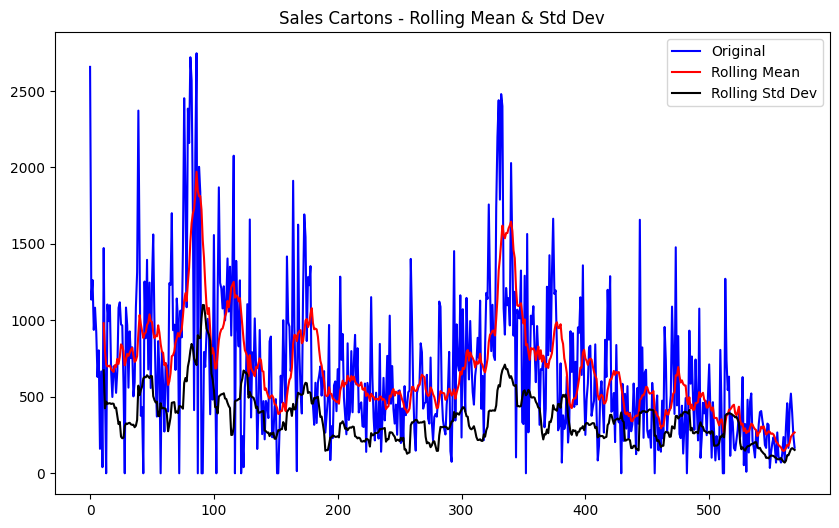

ADF Statistic: -5.626639024928065
p-value: 1.113503457073459e-06
Critical Values:
   1%: -3.4419770063102213
   5%: -2.866669060591297
   10%: -2.5695016312945413
Result: The series is stationary.


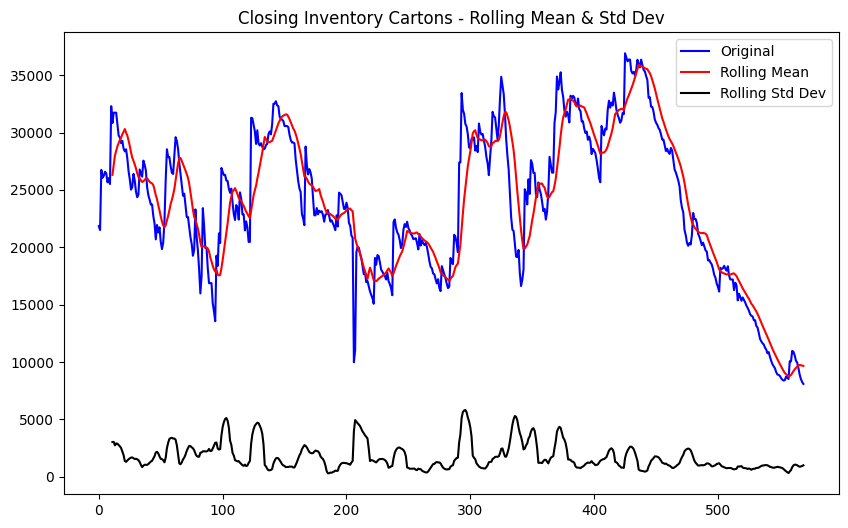

ADF Statistic: -2.138144297347794
p-value: 0.22945567230766034
Critical Values:
   1%: -3.4418948967017475
   5%: -2.8666329082535222
   10%: -2.569482366838501
Result: The series is not stationary.


In [9]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf

# Function to test stationarity using Augmented Dickey-Fuller test
def test_stationarity(series, title="Time Series"):
    # Rolling statistics
    rolmean = series.rolling(window=12).mean()
    rolstd = series.rolling(window=12).std()

    # Plot rolling statistics
    plt.figure(figsize=(10, 6))
    plt.plot(series, label='Original', color='blue')
    plt.plot(rolmean, label='Rolling Mean', color='red')
    plt.plot(rolstd, label='Rolling Std Dev', color='black')
    plt.legend()
    plt.title(f'{title} - Rolling Mean & Std Dev')
    plt.show()

    # Perform Augmented Dickey-Fuller test
    adf_test = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {adf_test[0]}')
    print(f'p-value: {adf_test[1]}')
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print(f'   {key}: {value}')
    if adf_test[1] <= 0.05:
        print("Result: The series is stationary.")
    else:
        print("Result: The series is not stationary.")

# Test stationarity for 'sales-cs'
test_stationarity(aggregated_data['sales-cs'], title="Sales Cartons")

# Test stationarity for 'closing-cs'
test_stationarity(aggregated_data['closing-cs'], title="Closing Inventory Cartons")


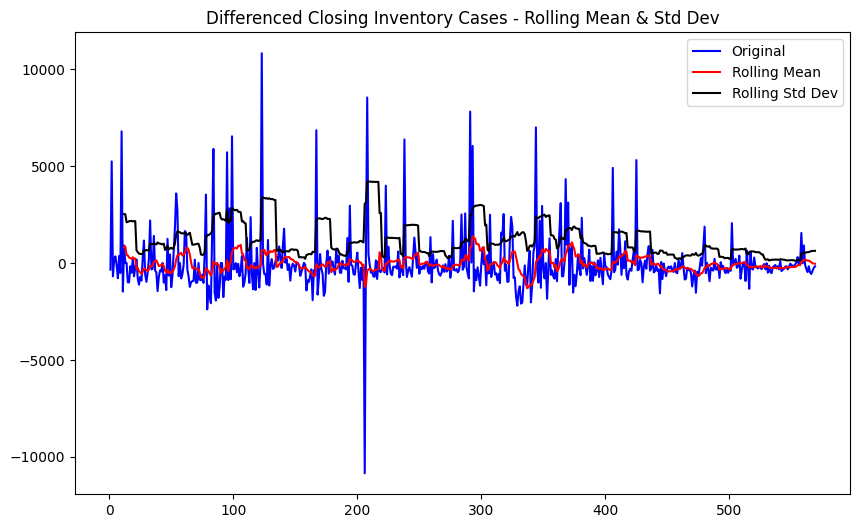

ADF Statistic: -23.935409745042374
p-value: 0.0
Critical Values:
   1%: -3.4419153151868147
   5%: -2.8666418984730146
   10%: -2.569487157434041
Result: The series is stationary.


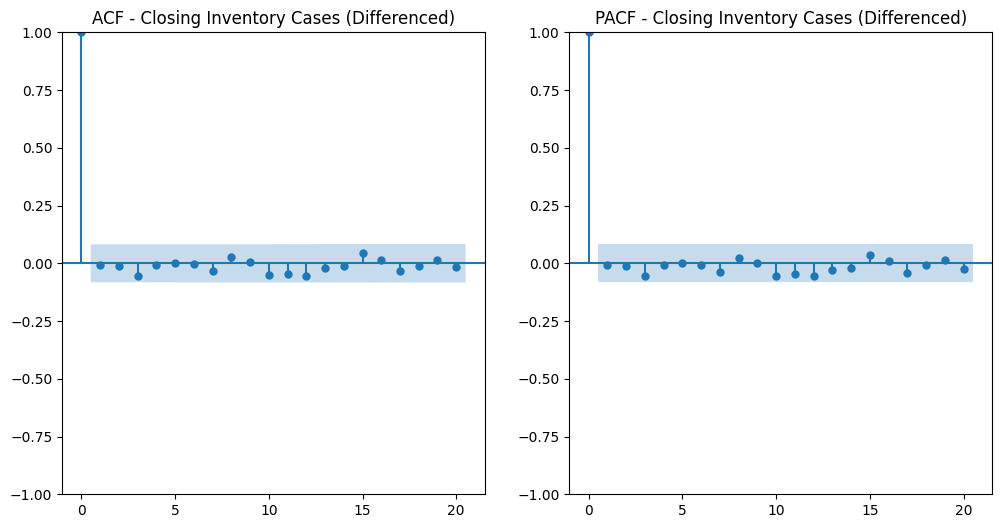

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Differencing the 'closing-cs' series to make it stationary
aggregated_data['closing-cs-diff'] = aggregated_data['closing-cs'].diff()

# Test stationarity after differencing
test_stationarity(aggregated_data['closing-cs-diff'].dropna(), title="Differenced Closing Inventory Cases")

# Plot ACF and PACF for differenced 'closing-cs'
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(aggregated_data['closing-cs-diff'].dropna(), ax=plt.gca(), lags=20)
plt.title('ACF - Closing Inventory Cases (Differenced)')

plt.subplot(122)
plot_pacf(aggregated_data['closing-cs-diff'].dropna(), ax=plt.gca(), lags=20)
plt.title('PACF - Closing Inventory Cases (Differenced)')
plt.show()


In [14]:
from statsmodels.tsa.arima.model import ARIMA

# Define and fit ARIMA model for sales-cs
sales_model = ARIMA(aggregated_data['sales-cs'], order=(4, 0, 16))  # No differencing needed (d=0)
sales_fit = sales_model.fit()

# Define and fit ARIMA model for closing-cs
closing_model = ARIMA(aggregated_data['closing-cs'], order=(1, 1, 1))  # Differencing applied (d=1)
closing_fit = closing_model.fit()

# Summarize the models
print("ARIMA Model Summary for Sales Cases:")
print(sales_fit.summary())

print("\nARIMA Model Summary for Closing Inventory Cases:")
print(closing_fit.summary())


C:\Users\saihe\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\saihe\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\saihe\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA Model Summary for Sales Cases:
                               SARIMAX Results                                
Dep. Variable:               sales-cs   No. Observations:                  570
Model:                ARIMA(4, 0, 16)   Log Likelihood               -4233.237
Date:                Mon, 16 Dec 2024   AIC                           8510.473
Time:                        14:14:57   BIC                           8606.077
Sample:                             0   HQIC                          8547.775
                                - 570                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        675.8546    172.240      3.924      0.000     338.271    1013.438
ar.L1          0.3252      2.097      0.155      0.877      -3.784       4.435
ar.L2          

In [15]:

forecast_steps = 30  # Assuming daily data, 30 days for next month

# Forecast sales
sales_forecast = sales_fit.forecast(steps=forecast_steps)

# Forecast inventory levels
closing_forecast = closing_fit.forecast(steps=forecast_steps)

# Create a dataframe to present the results
forecast_dates = pd.date_range(start=aggregated_data['date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_steps)
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Sales Forecast': sales_forecast,
    'Inventory Forecast': closing_forecast
})

# Display the forecasted results
forecast_df


,Date,Sales Forecast,Inventory Forecast
570,2024-01-01,334.053795,8111.329237
571,2024-01-02,332.224156,8094.048748
572,2024-01-03,318.946072,8109.497640
573,2024-01-04,334.029128,8095.686210
574,2024-01-05,325.958828,8108.033736
575,2024-01-06,351.083290,8096.994951
576,2024-01-07,340.503764,8106.863711
577,2024-01-08,360.895740,8098.040963
578,2024-01-09,393.559800,8105.928569
579,2024-01-10,335.312096,8098.876987


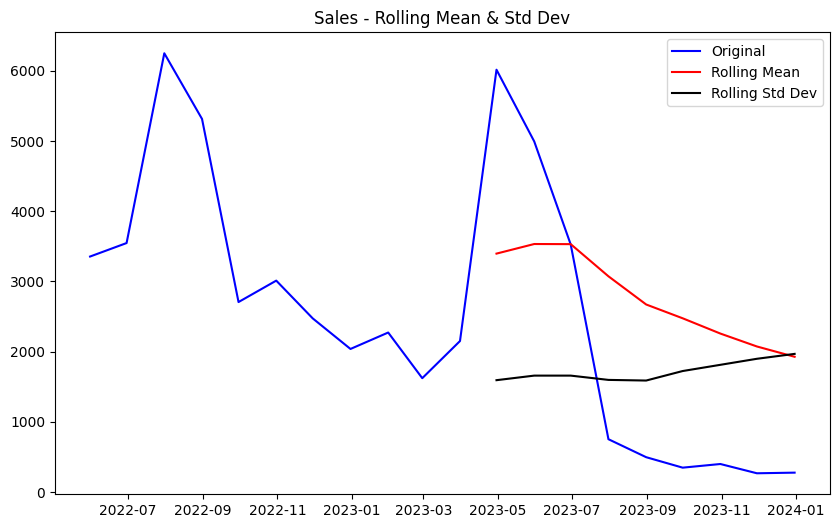

ADF Statistic: -0.3135334193685065
p-value: 0.9235656045157128
Critical Values:
   1%: -4.223238279489106
   5%: -3.189368925619835
   10%: -2.729839421487603
Result: The series is not stationary.


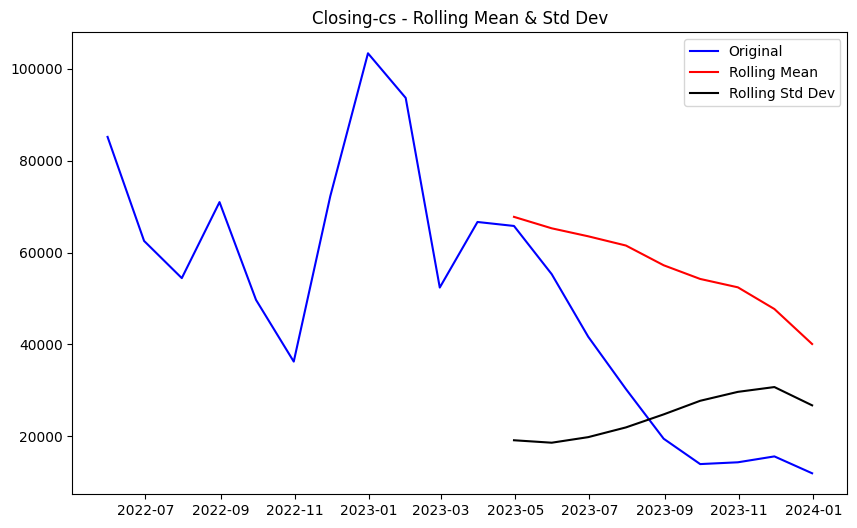

ADF Statistic: -8.71321026187597
p-value: 3.544954810684914e-14
Critical Values:
   1%: -4.223238279489106
   5%: -3.189368925619835
   10%: -2.729839421487603
Result: The series is stationary.


In [62]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

product_data = df[df['category'] == 0]

product_data = product_data[['date', 'sales-cs', 'closing-cs']]
product_data['date'] = pd.to_datetime(product_data['date'])
product_data.set_index('date', inplace=True)

# Aggregating data to monthly level for consistency with the previous analysis
product_monthly_data = product_data.resample('ME').sum()

test_stationarity(product_monthly_data['sales-cs'],title='Sales')
test_stationarity(product_monthly_data['closing-cs'],title='Closing-cs')



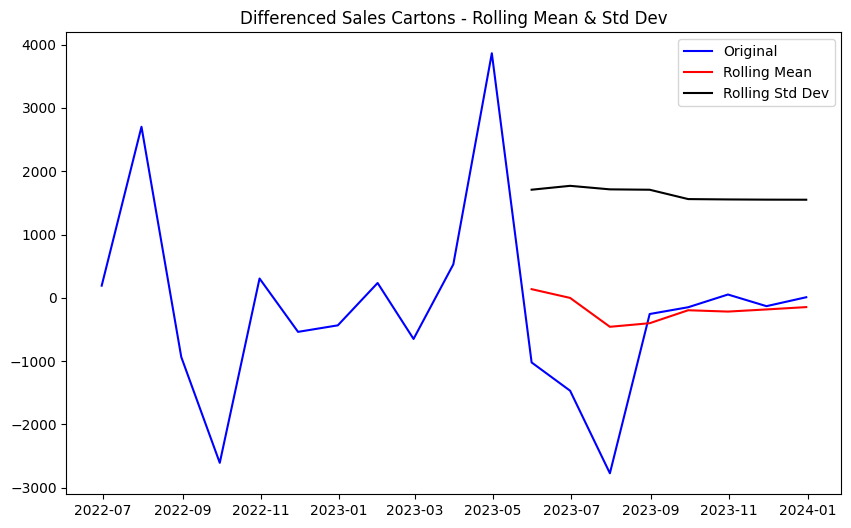

ADF Statistic: -8.718409687283666
p-value: 3.437918162456043e-14
Critical Values:
   1%: -4.223238279489106
   5%: -3.189368925619835
   10%: -2.729839421487603
Result: The series is stationary.


In [68]:
product_monthly_data['sales-cs-diff'] = product_monthly_data['sales-cs'].diff()

test_stationarity(product_monthly_data['sales-cs-diff'].dropna(), title="Differenced Sales Cartons")

In [88]:
train_sales = product_monthly_data['sales-cs']
train_closing = product_monthly_data['closing-cs']

sales_model = SARIMAX(train_sales, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit(disp=False)
closing_model = SARIMAX(train_closing, order=(1, 0, 1), seasonal_order=(1, 1, 1, 12)).fit(disp=False)

forecast_sales_product = sales_model.forecast(steps=6)
forecast_closing_product = closing_model.forecast(steps=6)

# Creating a combined dataframe for the forecasts
forecast_dates_product = pd.date_range(start=product_monthly_data.index[-1] + pd.DateOffset(1), periods=6, freq='ME')
forecast_product_df = pd.DataFrame({
    'Date': forecast_dates_product,
    'Forecasted Sales': forecast_sales_product.values,
    'Forecasted Closing Inventory': forecast_closing_product.values
})


forecast_product_df


C:\Users\saihe\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\saihe\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\saihe\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\saihe\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few obs

,Date,Forecasted Sales,Forecasted Closing Inventory
0,2024-01-31,318.456758,13250.246262
1,2024-02-29,424.682925,6756.828595
2,2024-03-31,602.848378,10686.384747
3,2024-04-30,863.457953,11181.601946
4,2024-05-31,4571.647941,77658.160783
5,2024-06-30,5202.887305,57298.055878


In [85]:
forecast_periods = 6  # Forecast the next 12 months
forecast = sales_model.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

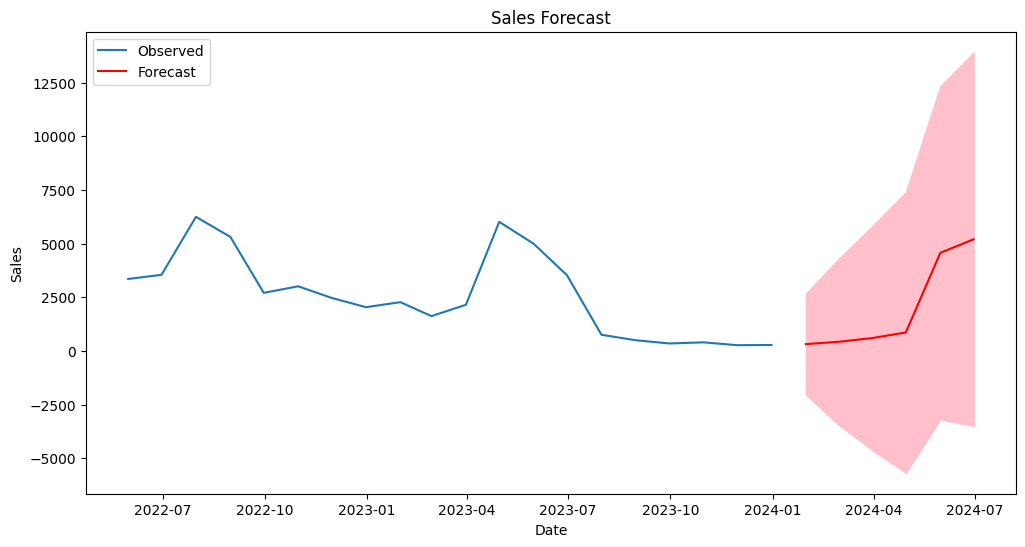

In [86]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(product_monthly_data['sales-cs'], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

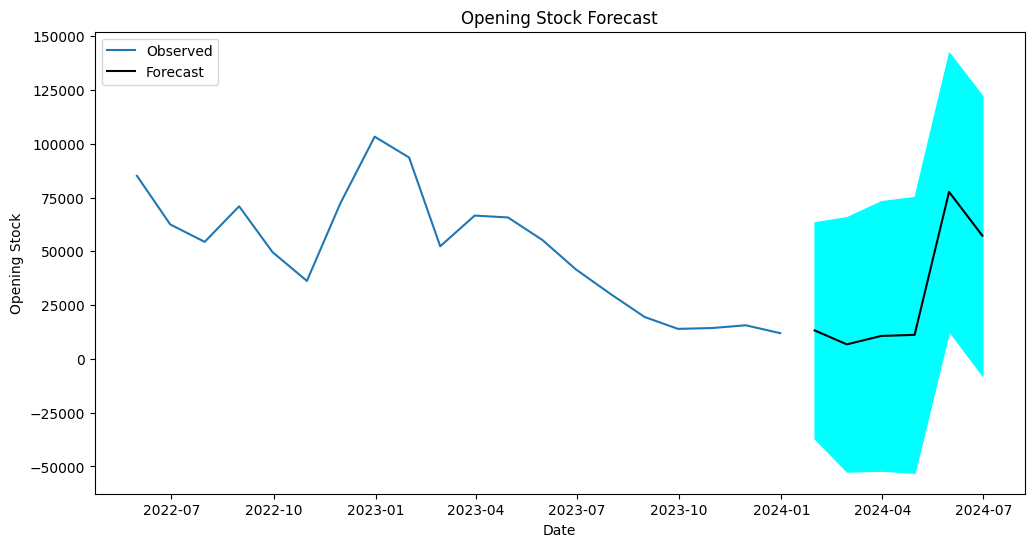

In [87]:
forecast_periods = 6  # Forecast the next 12 months
forecast = closing_model.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(product_monthly_data['closing-cs'], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='black')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='cyan')
plt.title("Opening Stock Forecast")
plt.xlabel("Date")
plt.ylabel("Opening Stock")
plt.legend()
plt.show()